# Deep Learning for HEP events classification
***
* Deep learning is a subfield of machine learning that uses neural networks with multiple layers to automatically learn patterns and relationships from data, enabling tasks like image recognition, natural language processing, and more.
* The basic unit is the artificial neuron (based in a very simple way on the biological neuron).
* The artificial nueron receives inputs from other neurons (or the initial input), combine the information and provide output value(s).
* Here, we will address a classification problem, using tabular data:



## The problem
***

* Event classification is one of the most common and fundamental tasks in the field of high-energy particle physics.
* An **event** corresponds to a proton collision generated in a particle collider, such as the Large Hadron Collider (LHC), and is represented by a set of physical properties measured by the collider's detectors.
* We want to classify events into signal and background categories.
  

## Python packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
#import tensorflow_addons as tfa


from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


## Getting the data
---
* Data is obtained from this [link](https://www.openml.org/d/23512).
* Each event is represented by a set of 28 features, including 21 low-level features corresponding to physics properties measured by the detector, and 7 high-level features derived from the previous ones.
* Some of the event's features:

|Type| Variable  | Description   |
|---| --- | --- |
|low-level|lepton pT |  Momentum of the lepton|
|low-level|lepton eta | Pseudorapidity eta of the lepton|
|low-level|lepton phi | Azimuthal angle phi of the lepton|
|low-level|Missing energy magnitude | Energy not detected|
|| ... | ...|
|high-level|m_jlv| Mass jet ($j$), lepton ($l$, electrons or muons), neutrino $\\nu$|
|high-level|m_bb| Mass quarks $b$|
|high-level|m_wbb| Mass boson $W$ and quarks $b$|
|high-level|m_wwbb|Mass bosons $W$ and quarks $b$|

In [2]:
df = pd.read_csv("../data/higgs_reduced.csv")

# !gdown https://drive.google.com/uc?id=1z_Y3Jmp8ntiN8egwGSfZl4_D_h5qmRRl
# df = pd.read_csv("/content/winequality-red.csv")

In [3]:
df.head()

,Unnamed: 0,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0,1.0,0.978916,1.844643,-1.422353,0.910926,1.741381,0.836740,1.038726,0.040076,...,0.509227,1.487003,0.000000,0.815551,1.017818,0.981035,1.173383,0.978406,0.987195,0.843390
1,1,0.0,0.785475,0.947617,1.601191,1.730936,-1.300155,0.898392,0.655507,1.034625,...,-0.129548,-0.258853,0.000000,1.666249,1.403631,0.986471,1.152768,1.342005,1.134370,1.092319
2,2,1.0,0.572818,-1.231151,-1.497259,0.557409,1.587439,2.817746,0.714921,-0.137981,...,-0.510981,1.181246,3.101961,2.894233,1.823246,0.998267,1.867427,2.785220,2.321026,1.750416
3,3,0.0,0.548844,2.153391,-0.562318,1.489274,0.248050,1.791746,-0.108951,1.369468,...,-0.621747,1.301107,3.101961,0.934149,0.871509,0.985588,0.821194,1.113907,1.328275,1.810306
4,4,1.0,0.846600,-0.158811,-1.235365,0.728787,-0.783034,1.155717,-0.462463,-0.844258,...,-1.235538,1.066934,0.000000,0.440971,0.965494,0.985530,1.133286,1.747692,0.984962,0.814022


In [4]:
df.columns

Index(['Unnamed: 0', 'class', 'lepton_pT', 'lepton_eta', 'lepton_phi',
       'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta',
       'jet1phi', 'jet1b-tag', 'jet2pt', 'jet2eta', 'jet2phi', 'jet2b-tag',
       'jet3pt', 'jet3eta', 'jet3phi', 'jet3b-tag', 'jet4pt', 'jet4eta',
       'jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb',
       'm_wbb', 'm_wwbb'],
      dtype='object')

In [5]:
df["class"].value_counts()

class
1.0    5201
0.0    4564
Name: count, dtype: int64

## Checking for missing values

In [6]:
def show_null(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data)
show_null(df)

,Total,Percent
m_wbb,61,0.006221
jet4pt,61,0.006221
m_jj,60,0.006119
jet4phi,60,0.006119
jet2b-tag,59,0.006017
jet1phi,59,0.006017
m_wwbb,56,0.005711
lepton_phi,54,0.005507
jet3phi,53,0.005405
jet4b-tag,52,0.005303


In [7]:
df = df.dropna() 

## Correlation Matrix

Text(0.5, 1.0, 'Correlation Heatmap')

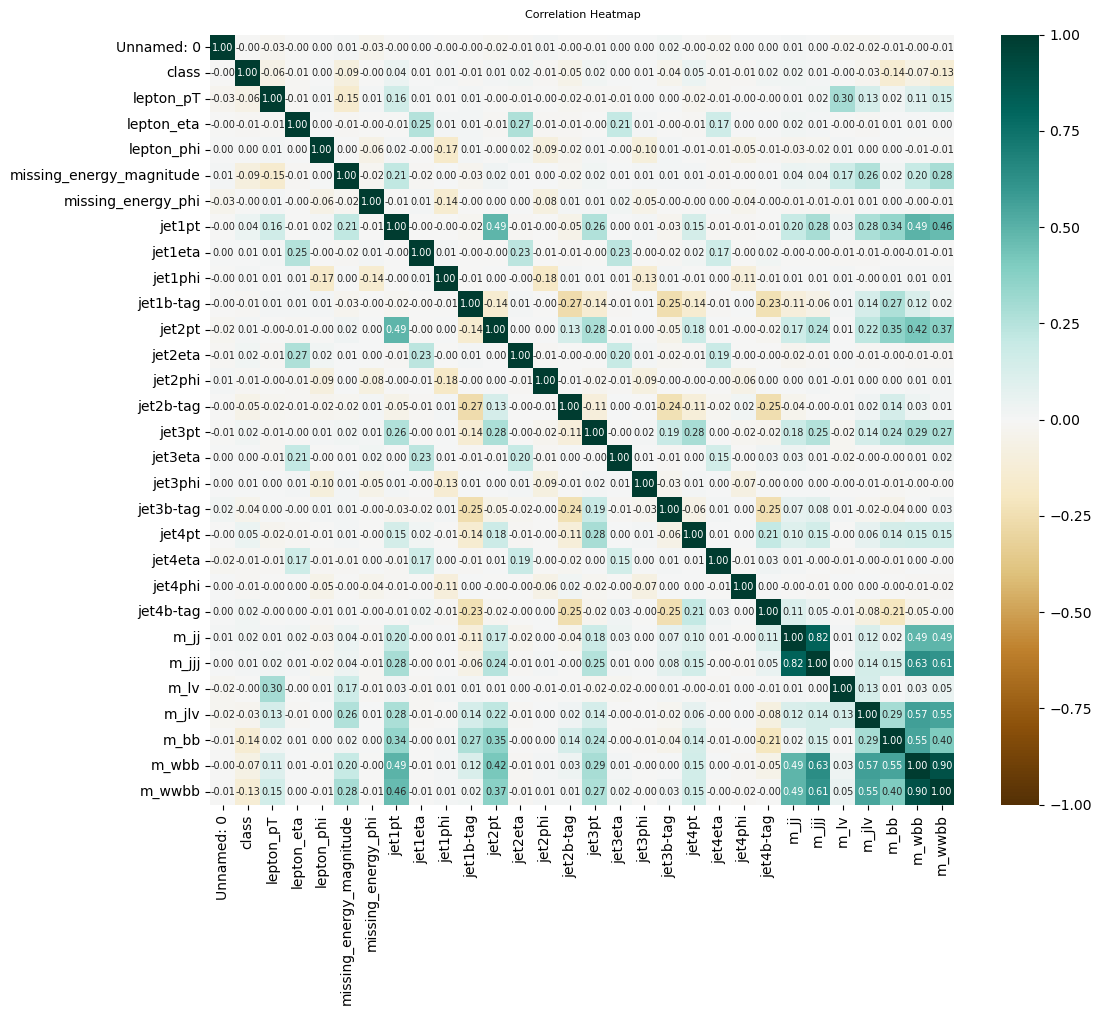

In [8]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG', annot = True, fmt=".2f", annot_kws={"size":7})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=12)

## Pair plots

/Users/rpezoa/anaconda3/envs/tensorflow-test/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


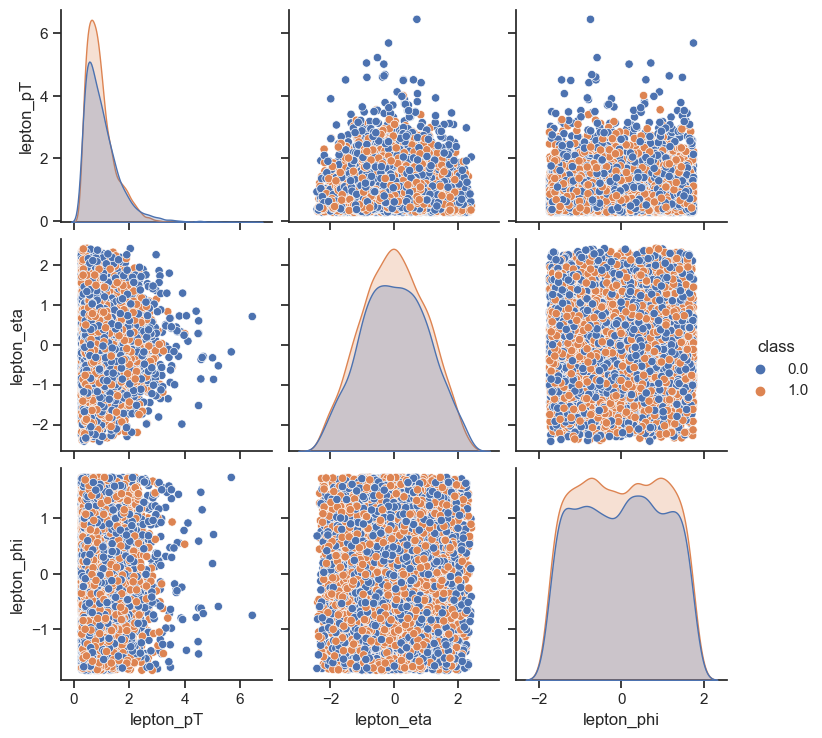

In [9]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df,vars = ['lepton_pT','lepton_eta','lepton_phi'], hue="class")
plt.show()

## Generating training, validation and testing datasets

In [10]:
y = df["class"]
y = y.astype(int)
X = df.iloc[:,2:-1]

In [11]:
X

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,jet2pt,...,jet4pt,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb
0,0.978916,1.844643,-1.422353,0.910926,1.741381,0.836740,1.038726,0.040076,2.173076,0.686552,...,0.795455,0.509227,1.487003,0.000000,0.815551,1.017818,0.981035,1.173383,0.978406,0.987195
1,0.785475,0.947617,1.601191,1.730936,-1.300155,0.898392,0.655507,1.034625,2.173076,0.633672,...,0.556672,-0.129548,-0.258853,0.000000,1.666249,1.403631,0.986471,1.152768,1.342005,1.134370
2,0.572818,-1.231151,-1.497259,0.557409,1.587439,2.817746,0.714921,-0.137981,1.086538,1.868912,...,1.784661,-0.510981,1.181246,3.101961,2.894233,1.823246,0.998267,1.867427,2.785220,2.321026
3,0.548844,2.153391,-0.562318,1.489274,0.248050,1.791746,-0.108951,1.369468,0.000000,1.112861,...,0.883568,-0.621747,1.301107,3.101961,0.934149,0.871509,0.985588,0.821194,1.113907,1.328275
4,0.846600,-0.158811,-1.235365,0.728787,-0.783034,1.155717,-0.462463,-0.844258,1.086538,1.193817,...,0.699552,-1.235538,1.066934,0.000000,0.440971,0.965494,0.985530,1.133286,1.747692,0.984962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,0.799018,-0.317568,1.511859,0.808901,-1.313098,0.535536,-0.907076,0.148179,2.173076,0.491779,...,1.092898,0.610832,-1.040172,0.000000,0.883996,1.002692,0.984474,0.855569,0.289925,0.742003
9801,1.755057,-0.861043,-1.700894,0.830647,0.650778,1.470479,1.164485,0.076110,2.173076,1.250348,...,0.505800,0.773232,-1.299871,0.000000,0.768177,0.988523,1.427038,2.413271,2.241379,1.727108
9802,0.462281,-1.868126,-1.482833,1.340225,1.480284,0.655266,-1.267520,-0.264933,2.173076,0.903106,...,0.594400,0.521720,-0.040773,0.000000,0.972735,1.055439,0.974570,0.861793,0.781094,0.811690
9803,0.477288,1.330387,0.218477,1.115468,-1.129730,0.563293,-0.780327,1.427123,2.173076,0.575883,...,0.719268,-1.241367,-1.415293,0.000000,1.133203,0.827060,0.985745,1.467714,0.744448,1.040776


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, 
                                                  test_size=0.2, random_state=0)
n_classes = 2

## Building a FFNN using Keras

In [13]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
import tensorflow  as tf



model = Sequential()
model.add(Dense(300, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(150, activation = "relu"))
model.add(Dense(100, activation = "relu"))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               8400      
                                                                 
 dense_1 (Dense)             (None, 150)               45150     
                                                                 
 dense_2 (Dense)             (None, 100)               15100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 73751 (288.09 KB)
Trainable params: 73751 (288.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
metrics_m = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=SGD(),
               loss='binary_crossentropy',
               metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

history = model.fit(X_train, y_train, epochs=50, 
                    verbose=1,
                    validation_data = (X_val, y_val))

Epoch 1/50
149/149 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.5056 - precision: 0.5330 - recall: 0.5440 - val_loss: 0.6947 - val_accuracy: 0.5198 - val_precision: 0.5211 - val_recall: 0.9206
Epoch 2/50
149/149 [==============================] - 0s 683us/step - loss: 0.6894 - accuracy: 0.5348 - precision: 0.5368 - recall: 0.8937 - val_loss: 0.6926 - val_accuracy: 0.5206 - val_precision: 0.5257 - val_recall: 0.7796
Epoch 3/50
149/149 [==============================] - 0s 680us/step - loss: 0.6868 - accuracy: 0.5510 - precision: 0.5507 - recall: 0.8313 - val_loss: 0.6916 - val_accuracy: 0.5349 - val_precision: 0.5330 - val_recall: 0.8379
Epoch 4/50
149/149 [==============================] - 0s 656us/step - loss: 0.6842 - accuracy: 0.5691 - precision: 0.5644 - recall: 0.8202 - val_loss: 0.6907 - val_accuracy: 0.5408 - val_precision: 0.5365 - val_recall: 0.8460
Epoch 5/50
149/149 [==============================] - 0s 666us/step - loss: 0.6817 - accuracy: 0.5

In [15]:
def show_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure()
    plt.plot(train_loss,'r', label="train")
    plt.plot(val_loss,'g', label="validation")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    
def show_metrics(y_pred,th):
    cm = confusion_matrix(y_test, y_pred>th)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    d = classification_report(y_test, y_pred > th,output_dict=True)
    display(pd.DataFrame.from_dict(d))
    return y_pred

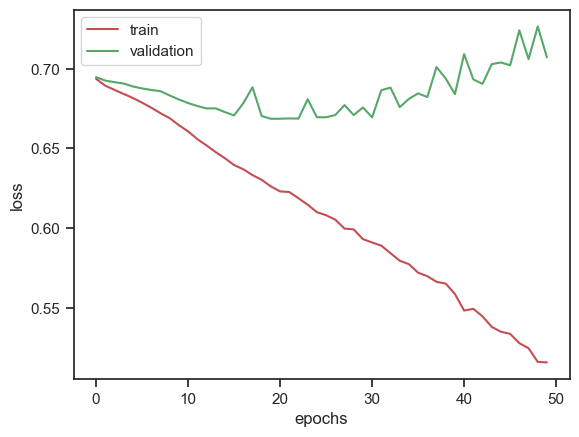

In [16]:
show_history(history)

In [17]:
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob >= 0.5

80/80 [==============================] - 0s 390us/step


## Showing performance metrics

In [18]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


fpr, tpr, ths = roc_curve(y_test,  y_pred)
auc_ = auc(fpr, tpr)
f1 = f1_score(y_test,  (y_pred>.5))
prec = precision_score(y_test,  (y_pred>.5))
rec = recall_score(y_test,  (y_pred>.5))
acc = accuracy_score(y_test,  (y_pred>.5))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.65  -- prec: 0.62  -- recall: 0.69  -- acc: 0.61


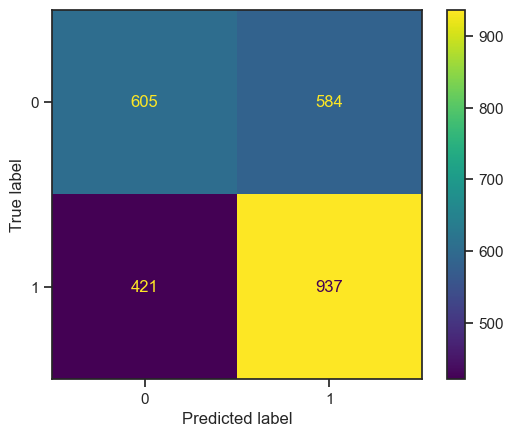

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              )
disp.plot()
plt.show()

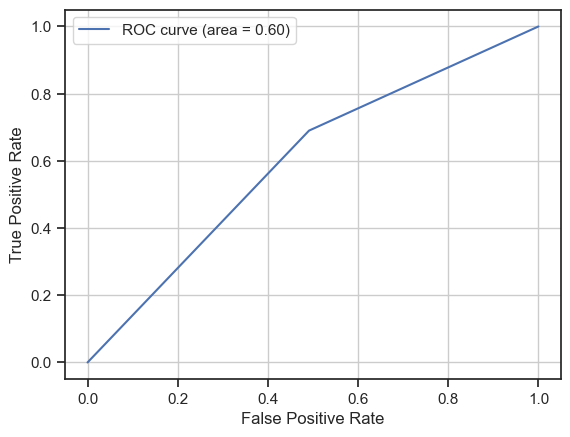

In [20]:
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [21]:
d = classification_report(y_test, y_pred,output_dict=True)

In [22]:
pd.DataFrame.from_dict(d)

,0,1,accuracy,macro avg,weighted avg
precision,0.589669,0.616042,0.605418,0.602855,0.603730
recall,0.508831,0.689985,0.605418,0.599408,0.605418
f1-score,0.546275,0.650920,0.605418,0.598598,0.602070
support,1189.000000,1358.000000,0.605418,2547.000000,2547.000000


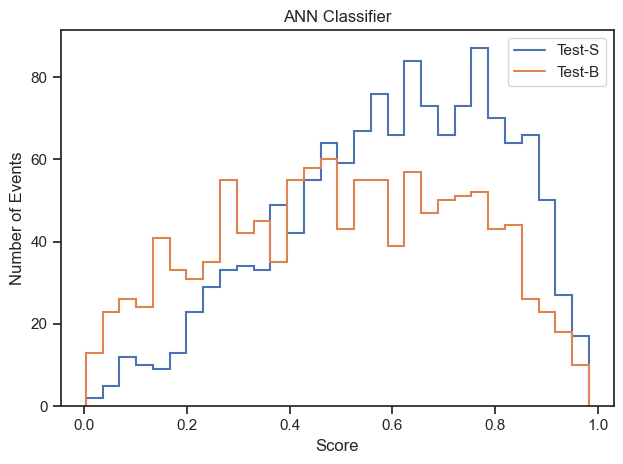

In [23]:
import mplhep as hep
# Score distribution
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_sig_test, bins_sig_test = np.histogram(y_pred_prob[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_prob[y_test == 0], bins=30)
axs.set_title("ANN Classifier")
hep.histplot([h_sig_test, h_back_test], bins_sig_test, ax=axs,label=["Test-S", "Test-B"])
axs.legend()
axs.set_xlabel("Score")
axs.set_ylabel("Number of Events")
plt.tight_layout()
plt.show()

## Using keras_tuner
****
 * To find the best hyperparameters for their machine learning models.

In [25]:
import keras_tuner as kt

In [26]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # Input Layer
    model.add(Dense(hp.Int('units_input', min_value=50, max_value=300, step=50), 
                    input_shape=(X_train.shape[1],), activation='relu'))
    
    # Hidden Layers
    for i in range(hp.Int('num_hidden_layers', 1, 4)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=50, max_value=300, step=50), 
                        activation='relu'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [33]:
# Instantiate the RandomSearch tuner
tuner = kt.RandomSearch(
    build_model, 
    objective='val_accuracy',
    max_trials=10,  # Number of models to try
    executions_per_trial=2,  # Number of times to train each model
    directory='my_dir',  # Directory to save the tuner results
    project_name='random_search_example'
)

# Search for the best model
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)



Reloading Tuner from my_dir/random_search_example/tuner0.json


In [34]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters:\n")
print(f"Input Layer Units: {best_hps.get('units_input')}")
for i in range(best_hps.get('num_hidden_layers')):
    print(f"Hidden Layer {i+1} Units: {best_hps.get(f'units_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the model on validation data
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")

Best hyperparameters:

Input Layer Units: 250
Hidden Layer 1 Units: 200
Learning Rate: 0.01
Epoch 1/20
149/149 [==============================] - 0s 1ms/step - loss: 0.7022 - accuracy: 0.5369 - val_loss: 0.6934 - val_accuracy: 0.5374
Epoch 2/20
149/149 [==============================] - 0s 751us/step - loss: 0.6718 - accuracy: 0.5822 - val_loss: 0.7013 - val_accuracy: 0.5349
Epoch 3/20
149/149 [==============================] - 0s 731us/step - loss: 0.6601 - accuracy: 0.6032 - val_loss: 0.6770 - val_accuracy: 0.5854
Epoch 4/20
149/149 [==============================] - 0s 733us/step - loss: 0.6498 - accuracy: 0.6030 - val_loss: 0.6850 - val_accuracy: 0.5795
Epoch 5/20
149/149 [==============================] - 0s 733us/step - loss: 0.6440 - accuracy: 0.6118 - val_loss: 0.6782 - val_accuracy: 0.5778
Epoch 6/20
149/149 [==============================] - 0s 729us/step - loss: 0.6396 - accuracy: 0.6291 - val_loss: 0.6759 - val_accuracy: 0.5887
Epoch 7/20
149/149 [==========================

In [35]:
y_pred_prob_2 = best_model.predict(X_test)
y_pred_2 = y_pred_prob_2 >= 0.5

80/80 [==============================] - 0s 381us/step


In [36]:
fpr, tpr, ths = roc_curve(y_test,  y_pred_2)
auc_ = auc(fpr, tpr)
f1 = f1_score(y_test,  (y_pred_2>.5))
prec = precision_score(y_test,  (y_pred_2>.5))
rec = recall_score(y_test,  (y_pred_2>.5))
acc = accuracy_score(y_test,  (y_pred_2>.5))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.65  -- prec: 0.60  -- recall: 0.71  -- acc: 0.59
